In [1]:
import sys 
import os

import pandas as pd
import pickle
import numpy as np
import scipy 
import matplotlib.pyplot as plt
from plot import plot_confusion_matrix

from pandas.core.index import CategoricalIndex, RangeIndex, Index, MultiIndex

/Users/colada/work_dir/Helvetas/helvetas/notebooks/plot.py:12: FutureWarning: pandas.core.index is deprecated and will be removed in a future version.  The public classes are available in the top-level namespace.
  from pandas.core.index import CategoricalIndex, RangeIndex, Index, MultiIndex


In [2]:
df_raw = pd.read_csv("/Users/colada/work_dir/Helvetas/helvetas/data/01_raw/Helvetas_H4G2020.csv", sep = ";")

In [3]:
df_raw.first_donation.isna().value_counts()

False    323656
Name: first_donation, dtype: int64

In [4]:
filepath =  "/Users/colada/work_dir/Helvetas/helvetas/data"
filename = "05_model_input/model_data.pkl"
filename2 = "04_feature/features_data.pkl"
df = pd.read_pickle("{}/{}".format(filepath, filename))
data_by = pd.read_pickle("{}/{}".format(filepath, filename2))
df_by = df.copy(deep = True)
df_by["gebjah"] = data_by.gebjah

In [5]:
# from sklearn.decomposition import PCA

# df_feature = df_by.drop(columns = ["gebjah", "label_age_at_acquisition"])
# X = StandardScaler().fit_transform(np.array(df_feature))
# PCA = PCA(n_components = 10)
# PCA.fit(X)

In [6]:
# PCA.explained_variance_ratio_

In [1]:
df.drop_duplicates()

# ML Regression

In [8]:
from sklearn.model_selection import train_test_split

df_model = df


label_col   = "label_age_at_acquisition"
feature_col =  df_model.columns.tolist()
feature_col.remove(label_col)
feature_col.remove("gebjah")

X = np.array(df_model[feature_col])
y = np.array(df_model[label_col])


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=None)

In [9]:
%%time 
#implementation of grid search
#parameter tuning

from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.pipeline import Pipeline

from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import VarianceThreshold,SelectFromModel, SelectKBest, chi2
from sklearn.preprocessing import StandardScaler



# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 300, num = 20)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(20, 120, num = 10)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True]


pipe  = Pipeline([
                ('standardscaler', StandardScaler()),
                ('rfr', RandomForestRegressor())
])

random_grid = {'rfr__n_estimators': n_estimators,
               'rfr__max_features': max_features,
               'rfr__max_depth': max_depth,
               'rfr__min_samples_split': min_samples_split,
               'rfr__min_samples_leaf': min_samples_leaf,
               'rfr__bootstrap': bootstrap}


regr_rf = pipe.fit(X_train, y_train)

clf = RandomizedSearchCV(estimator = regr_rf, param_distributions = random_grid, cv = 6, n_jobs = -1)
search = clf.fit(X_train, y_train)

CPU times: user 2min 1s, sys: 2.52 s, total: 2min 4s
Wall time: 13min 15s


In [10]:
best_params = search.best_params_
best_params

{'rfr__n_estimators': 226,
 'rfr__min_samples_split': 2,
 'rfr__min_samples_leaf': 1,
 'rfr__max_features': 'sqrt',
 'rfr__max_depth': 120,
 'rfr__bootstrap': True}

In [11]:
%%time
#cross validation#
#retraining with best params#

from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.pipeline import make_pipeline


kf = KFold(n_splits=10, random_state=None, shuffle=False)
selector = VarianceThreshold(threshold = (.8*(1- .8)))
stds     = StandardScaler()

MAE_cv = []


for train_index, test_index in kf.split(X_train):
    X_cv_train, X_cv_test = X[train_index], X[test_index]
    y_cv_train, y_cv_test = y[train_index], y[test_index]
    
    
    
    regr_rf  = make_pipeline(StandardScaler(), 
                             RandomForestRegressor(n_estimators = best_params["rfr__n_estimators"]
                                                   , max_depth = best_params["rfr__max_depth"], 
                                                   min_samples_split = 2, 
                                                   min_samples_leaf = 1,
                                                   max_features = "sqrt",
                                                   random_state=None,
                                                  criterion = "mse", 
                                                  ))
    regr_rf.fit(X_cv_train, y_cv_train)
    
    y_cv_pred = regr_rf.predict(X_cv_test)
    
    MAE_cv.append(mean_absolute_error(y_cv_pred, y_cv_test))

CPU times: user 3min 49s, sys: 5.28 s, total: 3min 54s
Wall time: 3min 55s


In [51]:
print("Mean absolute error for 10-fold Cross validation is: {}\nStandard deviation is : {}".format(np.mean(MAE_cv),
     np.std(MAE_cv)))


Mean absolute error for 10-fold Cross validation is: 8.242585196634632
Standard deviation is : 1.0074066719974266


In [12]:
#model fitting, performance evaluation#
# regr_rf  = make_pipeline(StandardScaler(), RandomForestRegressor(n_estimators = 150, criterion = "mse",
#                                                                          max_depth=2,  random_state=0))
regr_rf.fit(X_train, y_train)
y_pred = regr_rf.predict(X_test)
MAE    = mean_absolute_error(y_pred, y_test)
MAE_raw = mean_absolute_error(y_pred, y_test, multioutput='raw_values')


print("Mean absolute error for RandomForest is: {}".format(MAE))
    

Mean absolute error for RandomForest is: 7.697062718853666


In [14]:
regr_rf.Randomfeature_importances_

AttributeError: 'Pipeline' object has no attribute 'feature_importances_'

Text(0.5, 0, 'mean absolute error')

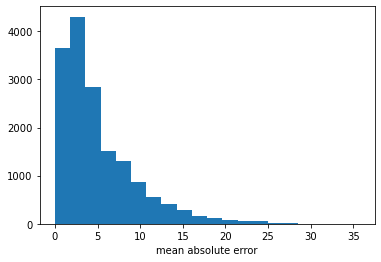

In [38]:
mae_per_sample =  np.abs(y_pred-y_test)
plt.hist(mae_per_sample, bins = 20)
plt.xlabel("mean absolute error")

In [32]:
# plt.scatter(y_test, y_pred)
good_list = [i for i,j in enumerate(y_pred) if np.abs(y_pred[i]-y_test[i])<= 5]
bad_list = [i for i,j in enumerate(y_pred) if np.abs(y_pred[i]-y_test[i])>= 10]
inter_list = [i for i,j in enumerate(y_pred) if np.abs(y_pred[i]-y_test[i])<= 10 and np.abs(y_pred[i]-y_test[i])> 5 ]


(array([5287., 2109.,  801.,  489.,  255.,  596.,  451.,   26.,  294.,
         268.]),
 array([17.452054794520564, 22.282042069017145, 27.112029343513722,
        31.9420166180103, 36.77200389250688, 41.60199116700346,
        46.431978441500036, 51.26196571599662, 56.0919529904932,
        60.92194026498978, 65.75192753948636], dtype=object),
 <a list of 10 Patch objects>)

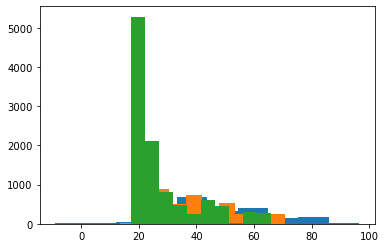

In [41]:
plt.hist(np.array(y_test)[bad_list])
plt.hist(np.array(y_test[inter_list]))
plt.hist(np.array(y_test)[good_list])

13977
2269


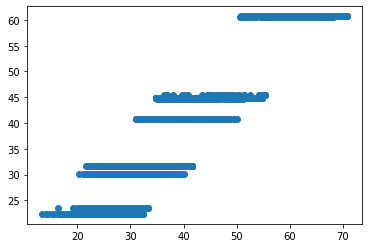

In [108]:
print(len(good_list))
print(len(bad_list))
plt.scatter(np.array(y_test)[good_list], np.array(y_pred)[good_list])

# Make a classification model

In [125]:
#make stratification#

def stra_label(gebjah):
    label = ""
    if gebjah <= 1951:
        label = "Reconstructor"
    elif gebjah > 1951 and gebjah <= 1966:
        label = "Boomer"
    elif gebjah > 1966 and gebjah <=1980:
        label = "GenX"
    elif gebjah > 1980 and gebjah <= 1994:
        label = "GenY"
    else:
        label = "GenZ"
        
    return label
    
# df_reconstructor = df_birth_corr.loc[df_birth_corr.gebjah <= 1951]
# df_boomer        = df_birth_corr.loc[(df_birth_corr.gebjah >= 1952) & (df_birth_corr.gebjah <= 1966)]
# df_genX          = df_birth_corr.loc[(df_birth_corr.gebjah >= 1967) & (df_birth_corr.gebjah <= 1980)]
# df_genY          = df_birth_corr.loc[(df_birth_corr.gebjah >= 1981) & (df_birth_corr.gebjah <= 1994)]
# df_genZ          = df_birth_corr.loc[df_birth_corr.gebjah >= 1995]

df_clf["clf_label"] = df_by.copy().apply(lambda x: stra_label(x["gebjah"]), axis = 1)

In [129]:
df_clf.clf_label.value_counts()

GenY             32102
GenX             19652
Boomer           13331
GenZ              8465
Reconstructor     7676
Name: clf_label, dtype: int64

In [139]:
df_clf = df_clf


label_col   = "clf_label"
feature_col =  df_model.columns.tolist()
feature_col.remove(label_col)
feature_col.remove("label_age_at_acquisition")
feature_col.remove("gebjah")

X_clf = np.array(df_clf[feature_col])
y_clf = np.array(df_clf[label_col])


X_train, X_test, y_train, y_test = train_test_split(X_clf, y_clf, test_size=0.33, random_state=None,
                                                   stratify = y_clf )

In [165]:
from sklearn.model_selection import KFold,StratifiedKFold
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import make_pipeline
from sklearn.feature_selection import VarianceThreshold,SelectFromModel, SelectKBest, chi2
from sklearn.preprocessing import StandardScaler


kf = StratifiedKFold(n_splits=10, random_state=None, shuffle=False)
selector = VarianceThreshold(threshold = (.8*(1- .8)))
stds     = StandardScaler()
labels = ["GenX", "GenY", "GenZ", "Boomer", "Reconstructor" ]

cm_cvs = []


for train_index, test_index in kf.split(X_train, y_train):
    X_cv_train, X_cv_test = X[train_index], X[test_index]
    y_cv_train, y_cv_test = y[train_index], y[test_index]
    
    
    
    clf_rf  = make_pipeline(selector, StandardScaler(), 
                             RandomForestClassifier(max_depth=2, random_state=0,
                                                  criterion = "entropy"))
    clf_rf.fit(X_cv_train, y_cv_train)
    
    y_cv_pred = clf_rf.predict(X_cv_test)
    
    cm_cv = confusion_matrix(y_cv_test, y_cv_pred, labels = labels)
    cm_cvs.append(cm_cv)


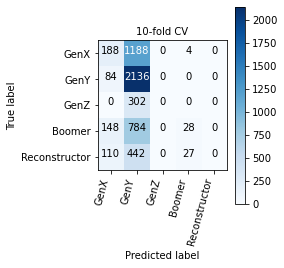

In [167]:
plot_confusion_matrix(np.mean(cm_cvs, axis = 0),
                      labels, title_real = "10-fold CV", 
                      normalize=False, cmap=plt.cm.Blues, png_output=None, show=True, ft = 10, fmt = '.0f')

In [172]:
#model fitting, performance evaluation#
clf_rf  = make_pipeline(selector, RandomForestClassifier(n_estimators = 150, criterion = "entropy",
                                                                         max_depth=2,  random_state=0))
clf_rf.fit(X_train, y_train)
y_pred = clf_rf.predict(X_test)
cm     = confusion_matrix(y_test, y_pred, labels = labels)


    

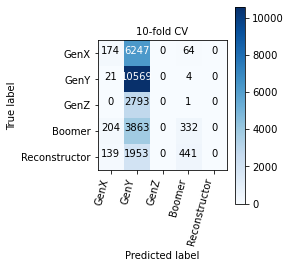

In [174]:
plot_confusion_matrix(cm,
                      labels, title_real = "10-fold CV", 
                      normalize=False, cmap=plt.cm.Blues, png_output=None, show=True, ft = 10, fmt = '.0f')

In [177]:
from sklearn.linear_model import LogisticRegression
clf_lr  = make_pipeline(selector, LogisticRegression(random_state=0, 
                                                     max_iter=10000))
clf_lr.fit(X_train, y_train)


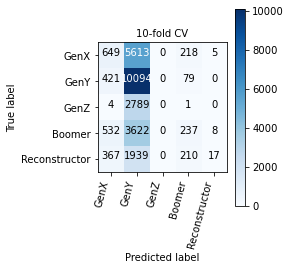

In [180]:
y_pred_lr = clf_lr.predict(X_test)
cv_lr = confusion_matrix(y_test, y_pred_lr, labels = labels,)

plot_confusion_matrix(cv_lr,
                      labels, title_real = "10-fold CV", 
                      normalize=False, cmap=plt.cm.Blues, png_output=None, show=True, ft = 10, fmt = '.0f')